In this tutorial we'll use pandas and sklearn. If you haven't already, you can install them with:

```shell
pip install pandas
pip install sklearn
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

We'll start by defining which dataset we'll use to train. We'll work with the well-known iris dataset.

In [2]:
# import some data to play with
from sklearn import datasets

iris = datasets.load_iris()
cls = iris.target
cls_names = iris.target_names

iris = pd.DataFrame(iris.data, columns=iris.feature_names)
iris['cls'] = cls

iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cls
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


Initially, our data will be the four first columns (the features); we'll only use cls when we're working with conditional flows later.

In [3]:
df = iris.drop('cls', 1)

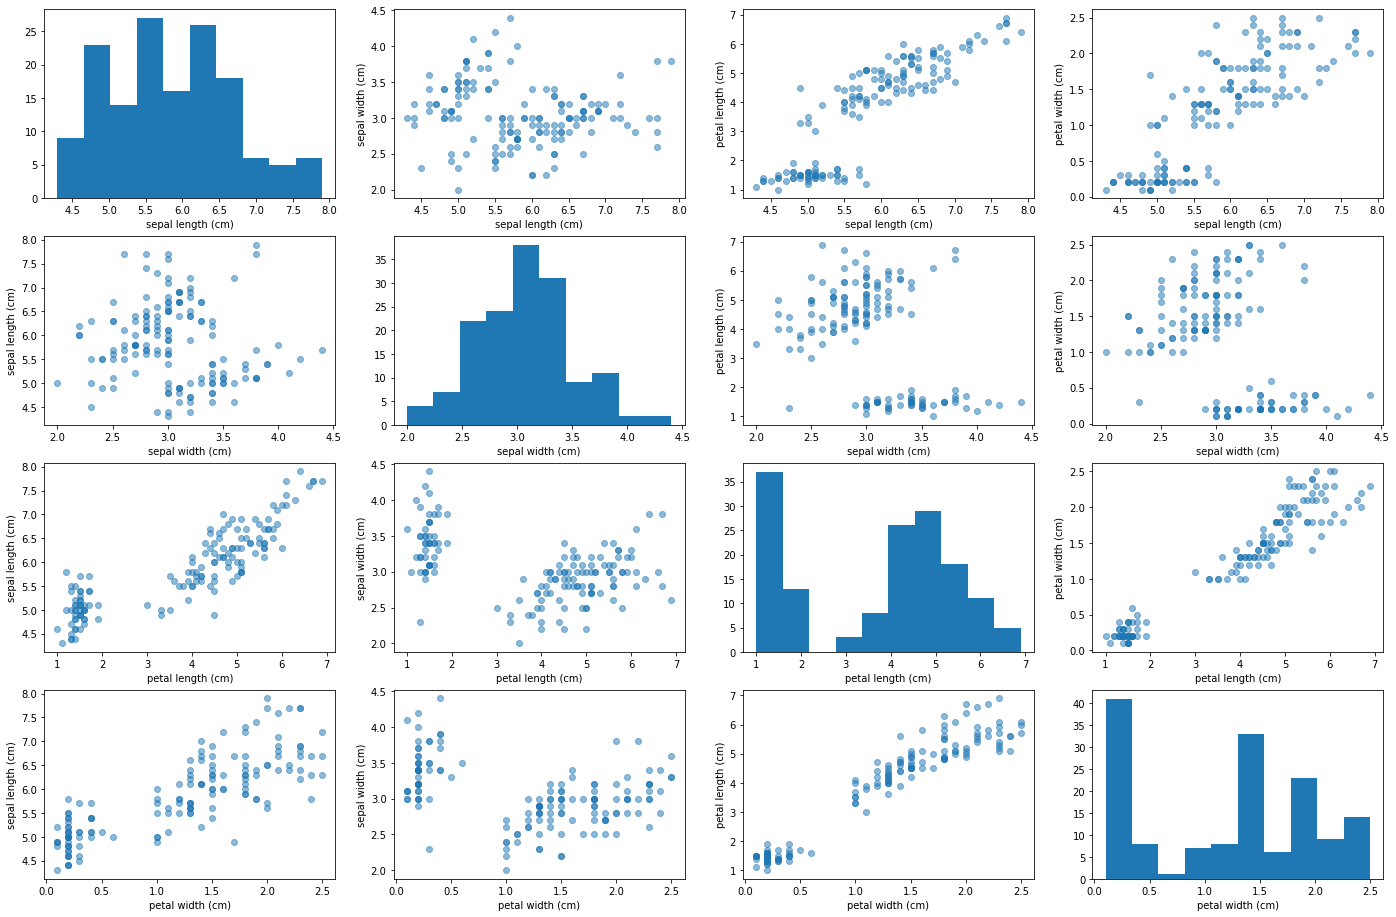

In [4]:
def plot_distribution(*dfs):
    # We can be given different DataFrames (either one or two)
    assert len(dfs) in (1, 2) # real, fake
    
    # Given a DataFrame with the distribution values, 
    # plot the scatter matrix for each 
    _, axes_mat = plt.subplots(4, 4, figsize=(6 * 4, 4 * 4))

    for i in range(4):
        for j in range(4):
            ax = axes_mat[i, j]
            
            for k, df in enumerate(dfs):
                label = 'real' if k == 0 else 'fake'
                if i == j:
                    ax.hist(df.values[:, i], alpha=.75 if len(dfs) > 1 else 1., label=label)
                else:
                    ax.scatter(df.values[:, i], df.values[:, j], alpha=.5, label=label)
                    
            ax.set_xlabel(df.columns[i])
            if i != j:
                ax.set_ylabel(df.columns[j])
               
            if len(dfs) > 1:
                ax.legend()
                
plot_distribution(df)

Let's transform our dataset into a torch Tensor, and divide into train, validation and test.

We'll then create a simple flow that learns the dataset distribution.

In [5]:
X = torch.Tensor(df.values)

np.random.seed(123)
torch.random.manual_seed(123)

split = np.random.choice(range(3), replace=True, size=len(X), p=[.5, .25, .25]) # train/val/test
split = torch.Tensor(split) # to tensor

trainX = X[split == 0]
valX = X[split == 1]
testX = X[split == 2]

Our flow will be a MADE - DSF combination. 

But, before that, it is important to normalize the original distribution. 
That's why we use BatchNorm first.

To concatenate several flows together, use the Sequential flow.
Its syntax is equivalent to torch.nn.Sequential.

Finally, we will train with the included train function, that trains flows with early stopping.

In [6]:
from flow import Sequential
from flow.modules import BatchNorm
from flow.conditioner import MADE
from flow.transformer import DSF
from flow.training import train, plot_losses, test_nll, get_device

In [7]:
device = get_device() # returns cuda if available, cpu otherwise
dim = trainX.size(1) # dimension of the flow, 4 in this case

flow = Sequential(
    BatchNorm(dim=dim),
    MADE(DSF(dim=dim)),  
).to(device)

741it [00:22, 33.62it/s, epoch_progress=100%, train_loss=+2.170e+00, last_val_loss=+1.709e+00, best_epoch=641, best_loss=+1.692e+00]


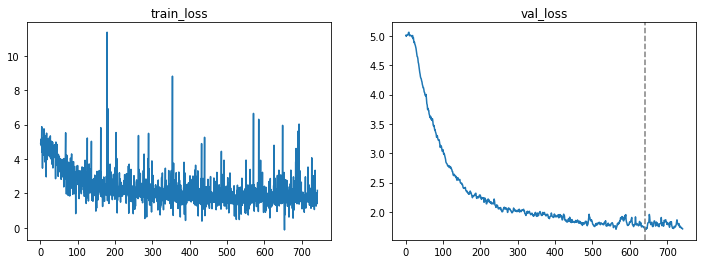

In [8]:
train_losses, val_losses = train(flow, trainX, valX, patience=100)

plot_losses(train_losses, val_losses)

Now that the flow is trained, we can sample and compute log-likelihoods with it.

In [9]:
test_nll(flow, testX) # average negative log-likelihood (nll) of the test set

2.1654152870178223

In [10]:
# Want to compute the nll of any sample? Use .nll(sample)

with torch.no_grad(): # no need for gradients now
    nll = flow.nll(testX.to(device)) # remember to move the tensor to the flow's device
    
nll[:5] # show the first 5 nlls of the test set

tensor([1.2292, 1.0723, 0.7480, 1.2149, 1.9829], device='cuda:0')

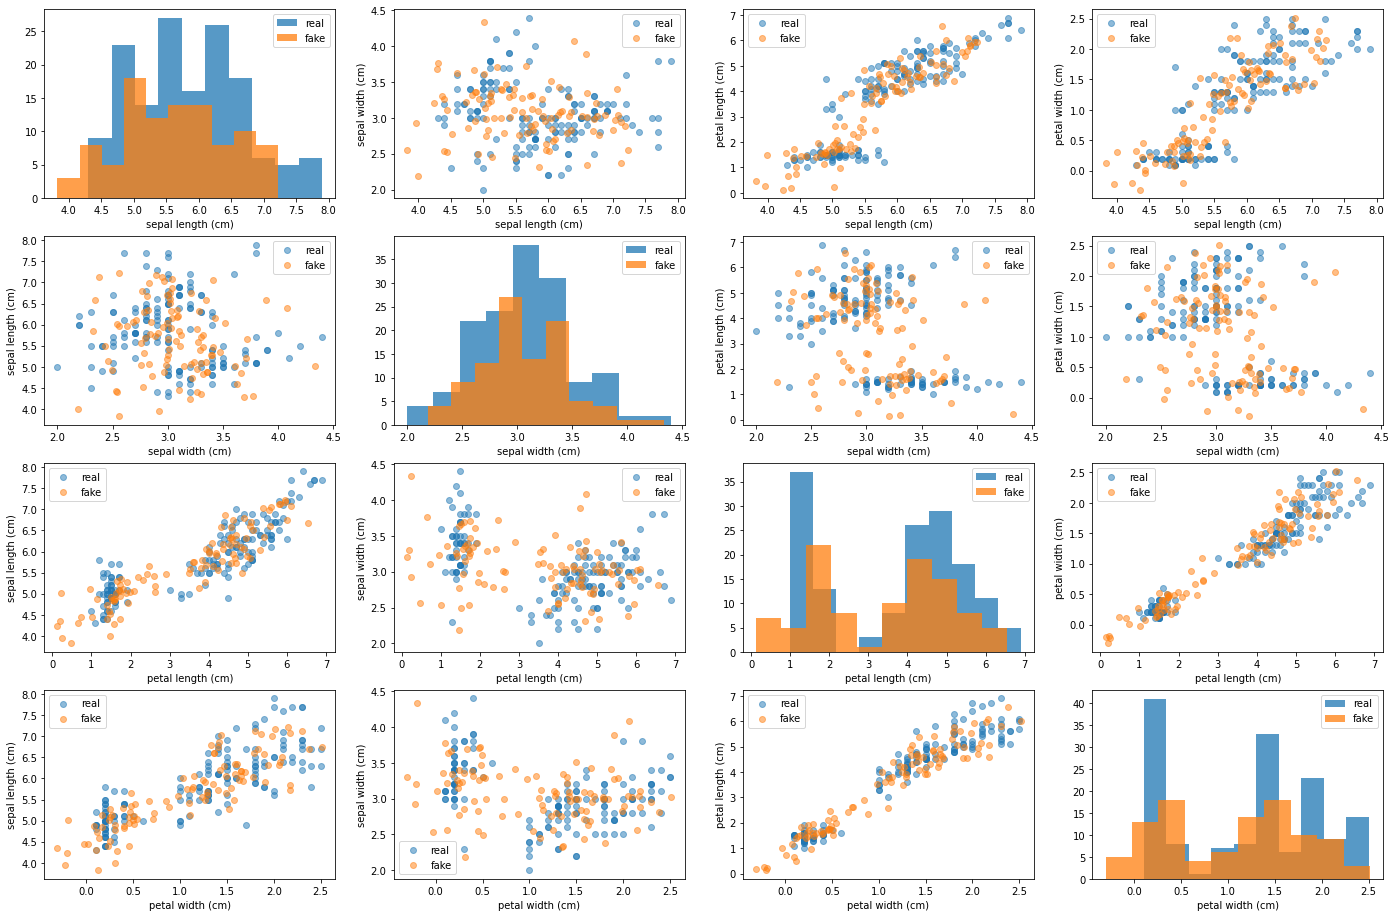

In [11]:
# Want to generate new samples from the learned distribution? Use .sample(N)

with torch.no_grad():
    sample = flow.sample(100)
    
# This returns a tensor in the flow's device.
# Let's move it to numpy and transform it to a DataFrame
# to plot it with plot_distribution
sample = pd.DataFrame(
    sample.cpu().numpy(),
    columns=df.columns
)

plot_distribution(df, sample)

# Conditional distribution

Conditional flows learn distributions conditioned on some values. In this case, conditioning on the class attribute (a 3-class Categorical distribution) we can model different probability distributions.

Conditional Flows are managed by the Conditioner. When defining a Conditional flow, pass `cond_dim` to the Conditioner's constructor. `cond_dim` is the dimensionality of the conditioning Tensor.

Then, when calling any of the flow's operation (forward, nll or sample) you need to pass the conditioning tensor for those samples as the `cond` keyword.

In [12]:
df = iris # get the original dataset with the 3 classes included

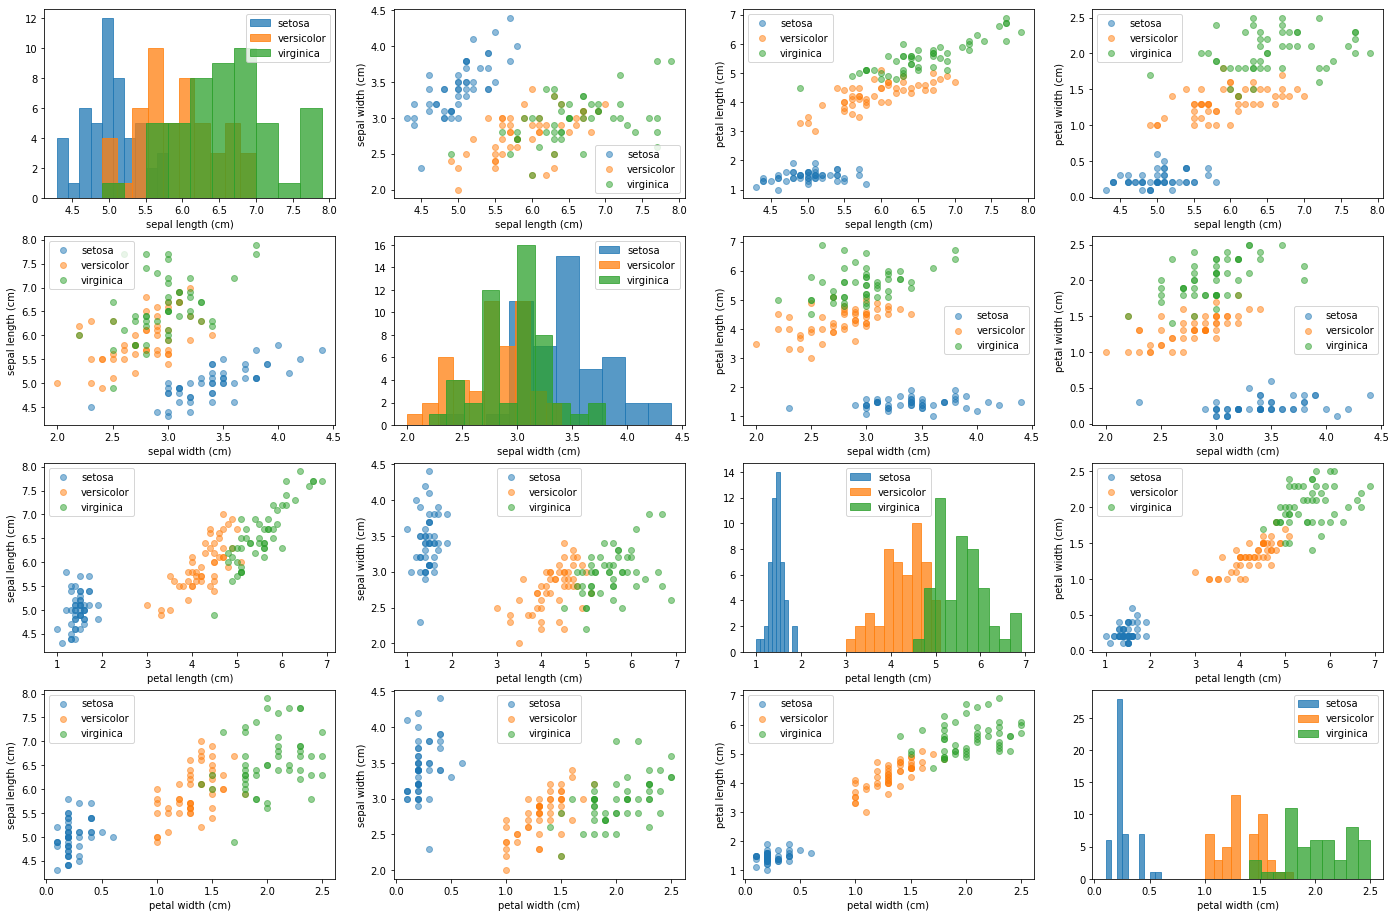

In [13]:
# For conditional distribution, we'll change the plot_distribution function
# to separate each group with a different colour. In the histogram,
# fake samples will not have fill and will be hatched instead.
# In the scatterplot, fake samples will be crosses instead of dots
def plot_distribution(*dfs):
    assert len(dfs) in (1, 2) # real, fake
    
    # Given a DataFrame with the distribution values, 
    # plot the scatter matrix for each 
    _, axes_mat = plt.subplots(4, 4, figsize=(6 * 4, 4 * 4))

    for i in range(4):
        for j in range(4):
            ax = axes_mat[i, j]
            
            for k, df in enumerate(dfs):
                for cls, cls_name in zip(range(3), cls_names):
                    subset = df[df.cls == cls].values
                    if i == j:
                        ax.hist(
                            subset[:, i],
                            color='C%d' % cls,
                            edgecolor='C%d' % cls, 
                            label=cls_name if k == 0 else None,
                            alpha=.75 if k == 0 else .5,
                            hatch='/' if k == 1 else None, 
                            fill=k == 0,
                        )
                    else:
                        ax.scatter(
                            subset[:, i], subset[:, j],
                            color='C%d' % cls,
                            label=cls_name if k == 0 else None,
                            marker=None if k == 0 else 'x',
                            alpha=.5,
                        )
                    
                    ax.set_xlabel(df.columns[i])
                    if i != j:
                        ax.set_ylabel(df.columns[j])

                    ax.legend()
                    
plot_distribution(df)

In [14]:
# If we're using conditional flows, we need the conditioning tensors
cond = torch.Tensor(df[['cls']].values)

cond_train = cond[split == 0]
cond_val = cond[split == 1]
cond_test = cond[split == 2]

In [15]:
device = get_device() # returns cuda if available, cpu otherwise
dim = trainX.size(1) # dimension of the flow, 4 in this case
cond_dim = cond_train.size(1) # dimension of the conditioning tensor

flow = Sequential(
    BatchNorm(dim=dim), # we don't need cond_dim here; 
    # BatchNorm will operate irrespective of the conditioning tensor
    
    MADE(DSF(dim=dim), cond_dim=cond_dim), # notice how we pass cond_dim?
).to(device)

706it [00:21, 33.57it/s, epoch_progress=100%, train_loss=+1.140e-02, last_val_loss=+7.611e-01, best_epoch=606, best_loss=+7.106e-01]


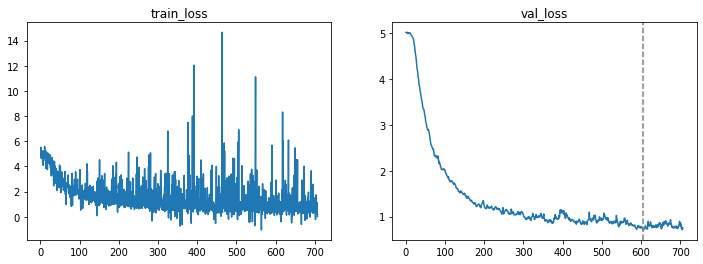

In [16]:
train_losses, val_losses = train(
    flow, trainX, valX, 
    # when calling train with a conditioning flow, you need to pass cond_train and cond_val
    cond_train=cond_train, cond_val=cond_val, 
    patience=100
)

plot_losses(train_losses, val_losses)

Now that the flow is trained, we can sample and compute log-likelihoods with it.

In [17]:
test_nll(flow, testX, cond_test) # also pass it to test_nll!

1.5059914588928223

In [18]:
# Want to compute the nll of any sample? Use .nll(sample, cond=cond)

with torch.no_grad(): # no need for gradients now
    nll = flow.nll(testX.to(device), cond=cond_test.to(device)) # remember to move the tensor to the flow's device
    
nll[:5] # show the first 5 nlls of the test set

tensor([ 0.1241,  0.0145, -0.0638, -0.2582,  0.3881], device='cuda:0')

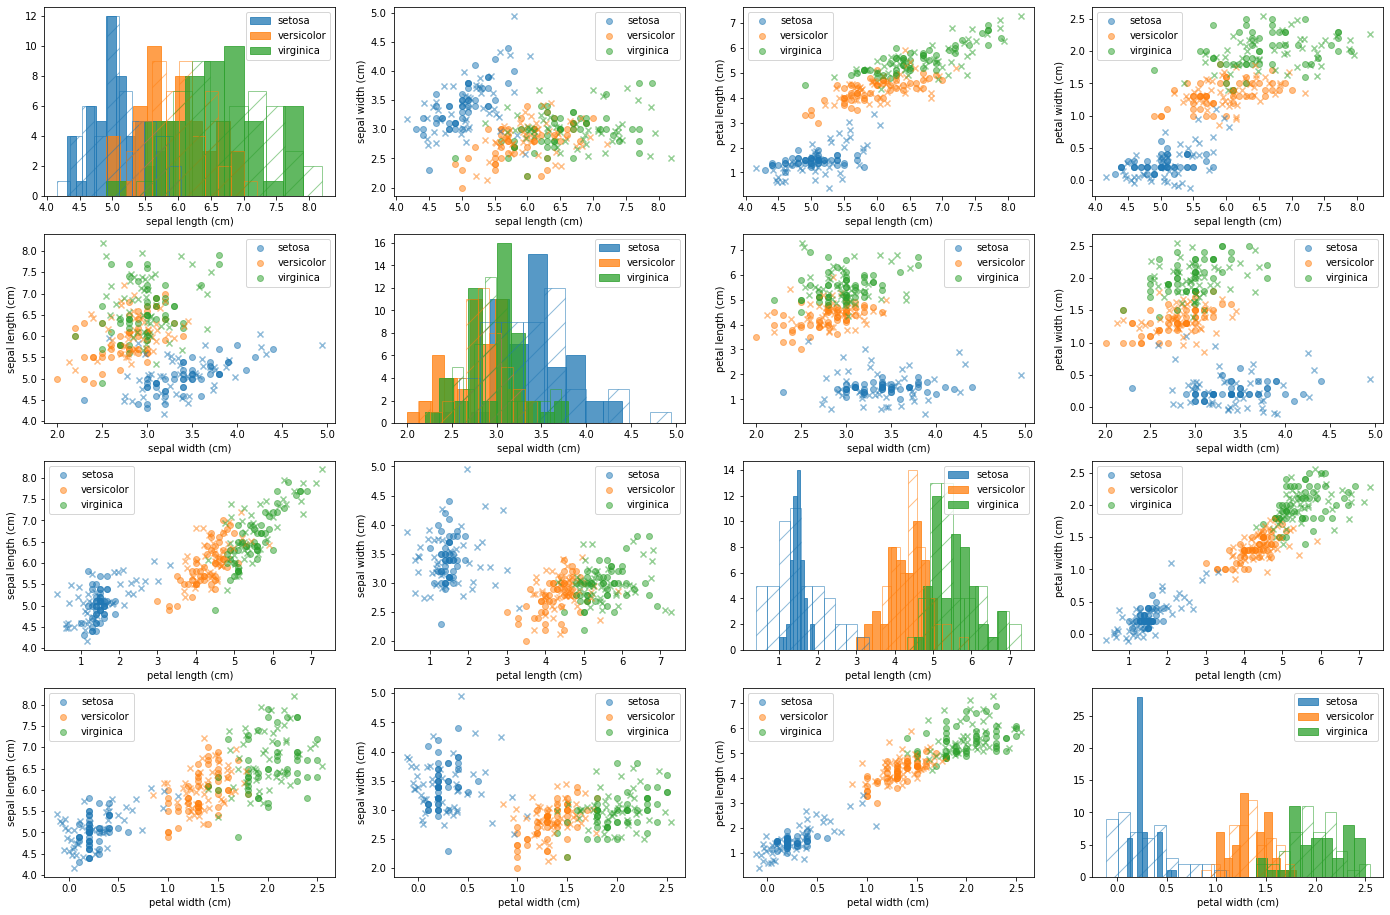

In [19]:
cond = cond.to(device)
with torch.no_grad():
    sample = flow.sample(len(cond), cond=cond)
    
# This returns a tensor in the flow's device.
# Let's move it to numpy and transform it to a DataFrame
# to plot it with plot_distribution
sample = torch.cat([sample, cond], 1) # don't forget to add cond
sample = pd.DataFrame(
    sample.cpu().numpy(),
    columns=df.columns
)

plot_distribution(df, sample)